## Import data

In [26]:
data_base_dir = "../behavior_clone_data/"
log_file = "driving_log.csv"

right_correction = lambda x: x-0.4
left_correction = lambda x: x+0.4

with open(data_base_dir+log_file) as f:
    center_image_path, left_image_path, right_image_path, steering = zip(*([(row.split(",")[0], 
                                                                            row.split(",")[1], 
                                                                            row.split(",")[2], 
                                                                            float(row.split(",")[3])
                                                                            ) for row in f][1:]))

image_path_all = center_image_path + left_image_path + right_image_path
steering_all = steering + tuple(map(left_correction, steering)) + tuple(map(right_correction, steering))


num of images: 22452


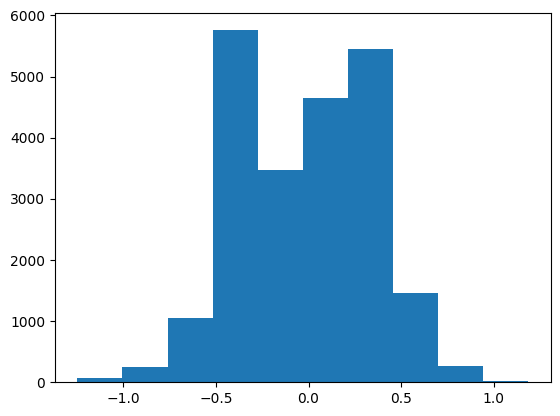

In [27]:
import matplotlib.pyplot as plt

print(f"num of images: {len(image_path_all)}")
plt.hist(list(map(float, steering_all)))
plt.show()

In [28]:
from sklearn.model_selection import train_test_split

train_image_path, valid_image_path, train_angle, valid_angle = train_test_split(image_path_all, steering_all, test_size=0.2, shuffle=True, random_state=100)


In [29]:
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import random


def generator(image_path, steering_angles, batch_size=32):
    num = len(image_path)
    while 1:
        image_path, steering_angles = sklearn.utils.shuffle(np.array(image_path), np.array(steering_angles))
        for offset in range(0, num, batch_size):
            image_path_batch = image_path[offset:offset+batch_size]
            steering_angle_batch = steering_angles[offset:offset+batch_size]
            
            images = []
            angles = []
            for file, angle in zip(image_path_batch, steering_angle_batch):
                # img = plt.imread(data_base_dir+file)
                img = plt.imread(file)
                if bool(random.getrandbits(1)):
                    images.append(img)
                    angles.append(angle)
                else:
                    images.append(np.fliplr(img))
                    angles.append(-angle)

            yield sklearn.utils.shuffle(np.array(images), np.array(angles))

batch_size=32
train_generator = generator(train_image_path, train_angle, batch_size=batch_size)
valid_generator = generator(valid_image_path, valid_angle, batch_size=batch_size)

In [30]:
# plt.imshow(next(train_generator)[0][0][60:140, :,:])

In [31]:
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Flatten, Dense, Conv2D, Dropout, ReLU
from math import ceil

ch, row, col = 3, 90, 320  # Trimmed image format
# set up model
model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/127.5 - 1,
        input_shape=(ch, row, col),
        output_shape=(ch, row, col)))
model.add(Conv2D(24, 5, 2, padding="valid", activation="elu"))
model.add(Dropout(0.2))
model.add(Conv2D(36, 5, 2, padding="valid", activation="elu"))
model.add(Dropout(0.2))
model.add(Conv2D(48, 5, 2, padding="valid", activation="elu"))
model.add(Dropout(0.2))
model.add(Conv2D(64, 3, 1, padding="valid", activation="elu"))
model.add(Dropout(0.2))
model.add(Conv2D(64, 3, 1, padding="valid", activation="elu"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation="elu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="elu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="elu"))
model.add(Dropout(0.2))
model.add(Dense(1))

Epoch 1/30


2023-11-17 19:51:03.046216: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


562/562 [==============================] - 25s 42ms/step - loss: 0.2122 - val_loss: 0.0998
Epoch 2/30
562/562 [==============================] - 24s 43ms/step - loss: 0.1188 - val_loss: 0.0977
Epoch 3/30
562/562 [==============================] - 24s 42ms/step - loss: 0.1081 - val_loss: 0.0904
Epoch 4/30
562/562 [==============================] - 24s 42ms/step - loss: 0.1004 - val_loss: 0.0958
Epoch 5/30
562/562 [==============================] - 24s 42ms/step - loss: 0.0939 - val_loss: 0.0786
Epoch 6/30
562/562 [==============================] - 23s 42ms/step - loss: 0.0870 - val_loss: 0.0818
Epoch 7/30
562/562 [==============================] - 23s 41ms/step - loss: 0.0810 - val_loss: 0.0743
Epoch 8/30
562/562 [==============================] - 21s 38ms/step - loss: 0.0774 - val_loss: 0.0703
Epoch 9/30
562/562 [==============================] - 21s 37ms/step - loss: 0.0653 - val_loss: 0.0373
Epoch 10/30
562/562 [==============================] - 21s 37ms/step - loss: 0.0469 - val_los

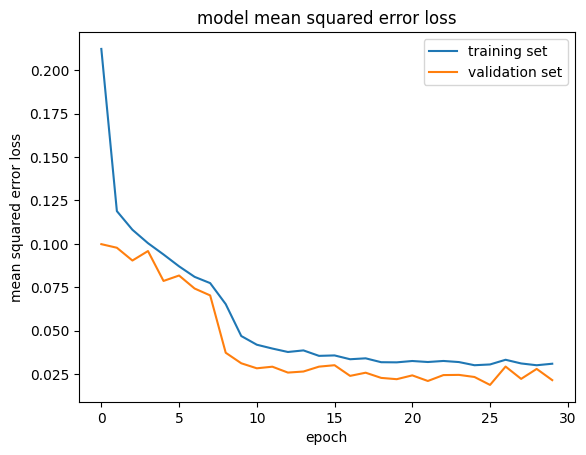

In [32]:
model.compile(loss='mse', optimizer='adam')
# steps_per_epoch give you the chance to "trick" the generator when updating the learning rate using ReduceLROnPlateau() callback
history_object  = model.fit(train_generator, 
                    steps_per_epoch=ceil(len(train_image_path)/batch_size),
                    epochs=30, 
                    validation_data=valid_generator,
                    validation_steps=ceil(len(valid_image_path)/batch_size),
                    verbose=1)

print(history_object.history.keys())
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
model.save("model/model.h5")

In [37]:
import numpy as np

np_center_image_path = np.array(center_image_path)
np_steering = np.array(steering)
fine_tune_image_path = np_center_image_path[(np_steering>0.2) | (np_steering<-0.2)]
fine_tune_steering = np_steering[(np_steering>0.2) | (np_steering<-0.2)]
# fine_tune_image_path = np_center_image_path
# fine_tune_steering = np_steering
train_image_path, valid_image_path, train_angle, valid_angle = train_test_split(fine_tune_image_path, fine_tune_steering, test_size=0.2, shuffle=True, random_state=10)
train_generator = generator(train_image_path, train_angle, batch_size=batch_size)
valid_generator = generator(valid_image_path, valid_angle, batch_size=batch_size)

Epoch 1/10


2023-11-17 20:13:09.361978: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 2s 47ms/step - loss: 0.0466 - val_loss: 0.0340
Epoch 2/10
27/27 [==============================] - 1s 43ms/step - loss: 0.0444 - val_loss: 0.0329
Epoch 3/10
27/27 [==============================] - 1s 47ms/step - loss: 0.0498 - val_loss: 0.0315
Epoch 4/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0434 - val_loss: 0.0326
Epoch 5/10
27/27 [==============================] - 1s 34ms/step - loss: 0.0433 - val_loss: 0.0342
Epoch 6/10
27/27 [==============================] - 1s 34ms/step - loss: 0.0461 - val_loss: 0.0289
Epoch 7/10
27/27 [==============================] - 1s 37ms/step - loss: 0.0405 - val_loss: 0.0342
Epoch 8/10
27/27 [==============================] - 1s 33ms/step - loss: 0.0429 - val_loss: 0.0315
Epoch 9/10
27/27 [==============================] - 1s 36ms/step - loss: 0.0439 - val_loss: 0.0333
Epoch 10/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0416 - val_loss: 0.0204
dict_keys(['loss', '

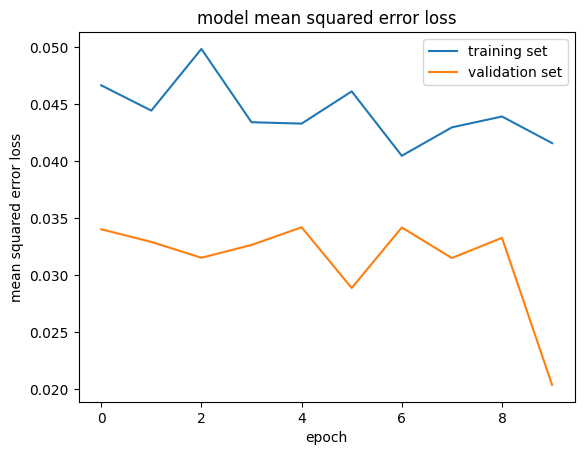

In [38]:
from keras.models import load_model

model = load_model("./model/model.h5")
for layer in model.layers[:12]:
    layer.trainable=False

history_object  = model.fit(train_generator, 
                    steps_per_epoch=ceil(len(train_image_path)/batch_size),
                    epochs=10, 
                    validation_data=valid_generator,
                    validation_steps=ceil(len(valid_image_path)/batch_size),
                    verbose=1)

print(history_object.history.keys())
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
model.save("model/model.h5")